In [97]:
%matplotlib inline
import torch
import torch.nn as nn
import spacy
import gutenberg.acquire
import gutenberg.cleanup
import string
# from tqdm import tqdm
from tqdm import tqdm_notebook as tqdm 
import matplotlib.pyplot as plt
from livelossplot import PlotLosses
import random

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [5]:
import pickle
import os

def read_or_pickle(path, load_default):
    path += '.pickle'
    if os.path.isfile(path):
        return pickle.load(open(path, 'rb'))
    else:
        data = load_default()
        pickle.dump(data, open(path, 'wb'))
        return data

def load_book(id):
    return gutenberg.cleanup.strip_headers(gutenberg.acquire.load_etext(id)).strip()

In [6]:
class CharRNN(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size, model, n_layers):
        super().__init__()

        self.encoder = nn.Embedding(input_size, hidden_size)
        if model == 'gru':
            self.rnn = nn.GRU(hidden_size, hidden_size, n_layers)
        else:
            self.rnn = nn.LSTM(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size) 

    def forward(self, inp, hidden):
        batch_size = inp.size(0)
        encoded = self.encoder(inp)
        output, hidden = self.rnn(encoded.view(1, batch_size, -1), hidden)
        output = self.decoder(output.view(batch_size, -1))
        return output, hidden

In [94]:
def char_tensor(chars_ix):
    return torch.tensor(chars_ix, dtype=torch.long, device=device)


def random_training_set(doc, doc_len, chunk_len, batch_size):
    inp = torch.zeros(batch_size, chunk_len, dtype=torch.long, device=device)
    target = inp.clone()

    for i in range(batch_size):
        start_index = random.randrange(doc_len - (chunk_len + 1))
        end_index = start_index + chunk_len + 1
        chunk = doc[start_index:end_index]
        inp[i] = char_tensor(chunk[:-1])
        target[i] = char_tensor(chunk[1:])

    return inp, target

In [131]:
def train(vocab, inp, target, net, criterion, optimizer, teacher_ratio):
    batch_size = inp.size(0)
    hidden = None
    net.zero_grad()
    loss = 0

    for i in range(inp.size(1)):
        if i == 0 or random.random() < teacher_ratio:
            actual_inp = inp[:, i]
        else:
            actual_inp = torch.zeros(
                batch_size, 1, dtype=torch.long, device=device)
            for bi, max_i in enumerate(last_output.argmax(1)):
                actual_inp[bi] = max_i
        output, hidden = net(actual_inp, hidden)
        output = output.view(batch_size, -1)
        last_output = output
        loss += criterion(output.view(batch_size, -1), target[:, i])

    loss.backward()
    optimizer.step()

    return loss.item() / inp.size(1)

In [132]:
def run_train(doc,
              doc_len,
              net,
              criterion,
              optimizer,
              n_epochs,
              chunk_len,
              batch_size,
              teacher_ratio,
              plot_every=1):
    losses = []

    for epoch in tqdm(range(n_epochs)):
        inp, target = random_training_set(doc, doc_len, chunk_len, batch_size)
        loss = train(vocab, inp, target, net, criterion, optimizer,
                     teacher_ratio)

        if DEBUG:
            return

        if LIVE_PLOT:
            liveloss.update({'loss': loss / plot_every})
            liveloss.draw()

        losses.append(loss / plot_every)

    plt.figure()
    plt.plot(losses)

    print(f'Final loss: {losses[-1]}')

In [119]:
def to_index(string):
    return list(map(vocab.index, string))


doc = load_book(84)
vocab = list(set(doc))
doc = to_index(doc)
doc_len = len(doc)

In [141]:
DEBUG = False
LIVE_PLOT = False
liveloss = PlotLosses()
hidden_size = 100
n_layers = 2
model = 'gru'
learning_rate = 0.01
n_epochs = 3000
chunk_len = 200
batch_size = 100
teacher_ratio = .8

net = CharRNN(len(vocab), hidden_size, len(vocab), model, n_layers).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

Final loss: 1.8885369873046876


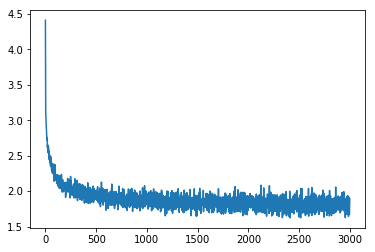

In [142]:
run_train(doc, doc_len, net, criterion, optimizer, n_epochs, chunk_len, batch_size, teacher_ratio)
torch.save(net.state_dict(), 'state.pt')

In [158]:
net.load_state_dict(torch.load('state.pt'))

def sample(vocab, net, prime_str, predict_len, temperature, beam_number):
    with torch.no_grad():
        prime_str = to_index(prime_str)

        hidden = None
        prime_inp = char_tensor(prime_str).unsqueeze(0)
        for i in range(len(prime_str)):
            _, hidden = net(prime_inp[:, i], hidden)
        
        result = prime_str
        for i in range(predict_len):
            inp = char_tensor(result[-1]).unsqueeze(0)
            output, hidden = net(inp, hidden)
            output_dist = output.data.view(-1)
            result.append(output_dist.argmax().item())
            
            
        return ''.join([vocab[i] for i in result])

        beams = [(hidden, prime_str)]

        for i in range(predict_len):
            output_pairs = []
            new_hidden = []
            for beami, (hidden, result) in enumerate(beams):
                inp = char_tensor(result[-1]).unsqueeze(0)
                output, hidden = net(inp, hidden)
                output_dist = output.data.view(-1).div(temperature).exp()

                output_pairs.extend([
                    (i, out.item(), beami) 
                    for i, out in enumerate(output_dist)])
                new_hidden.append(hidden)

            output_pairs.sort(key=lambda pair: pair[1], reverse=True)

            new_beams = []
            for outi, _outv, beami in output_pairs[:beam_number]:
                current_result = beams[beami][1]
                new_result = list(current_result)
                new_result.append(outi)
                new_beams.append((new_hidden[beami].clone(), new_result))
            beams = new_beams

        return list(
            map(lambda beam: ''.join(map(lambda i: vocab[i], beam[1])),
                new_beams))



In [164]:
prime_str = 'Once upon a'
predict_len = 1000
temperature = 0.1
beam_number = 2

res = sample(vocab, net, prime_str, predict_len, temperature, beam_number)
print(res)
"""
for pred in :
    print('===START===')
    print(pred)
    print('\n\n')
"""

Once upon all and aound that I had been the seat the sound of the sountains of the sease of the sease of the same seas of the sountains of the sease of the same seas of the sountains of the sease of the same seas of the sountains of the sease of the same seas of the sountains of the sease of the same seas of the sountains of the sease of the same seas of the sountains of the sease of the same seas of the sountains of the sease of the same seas of the sountains of the sease of the sease of the same seas of the sountains of the sease of the sease of the same seas of the sountains of the sease of the sease of the same seas of the sountains of the sease of the sease of the same seas of the sountains of the sease of the sease of the same seas of the sountains of the sease of the sease of the same seas of the sountains of the sease of the sease of the same seas of the sountains of the sease of the sease of the same seas of the sountains of the sease of the sease of the same seas of the sount

"\nfor pred in :\n    print('===START===')\n    print(pred)\n    print('\n\n')\n"